In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
df_path = "./marketplace.csv"

df = pd.read_csv(df_path)

# Гипотеза №1

In [3]:
# проверка на наличие записей, где сумма покупок меньше суммы возвратов
buys_lt_return = df["total_buy"] < df["total_return"]

# удаление этих записей
df = df.drop(df[buys_lt_return].index)

# проверка на наличие записей, где значение target
# не соответствует рассчетной формуле: (0.3 - (сумма возвратов / сумма покупок))
lower_target = -0.7
upper_target = 0.3

incorrect_target_values = df[~((lower_target <= df["target"]) & (df["target"] <= upper_target))]

df = df.drop(incorrect_target_values.index)

# отношение суммы возвратов к покупкам
df["current_target"] = np.where(
    df["total_buy"] != 0, 
    0.3 - (df["total_return"] / df["total_buy"]), 
    0
)

# совершались ли возвраты
df["was_return"] = df["current_target"] < 0.3

### Построение нулевой и альтернативной гипотез.

Проверка разницы среднего `target` в двух группах при разделении `current_target` по пороговому значению `threshold` и признаку `was_return`, где `high_target_return = current_target >= threshold`, `low_target_return = current_target < threshold` и `was_return is True`:
 - Нулевую гипотеза H<sub>0</sub>: "Средние показатели `target` равны для обеих групп"
 - Альтернативная гипотеза H<sub>1</sub>: "Средний показатель `target` у группы `low_target_return` меньше, чем у `high_target_return`"

### Выбор уровня значимости.

Примем уровень значимости на уровне `alpha = 0.05`

### Данные для проверки гипотезы.

In [4]:
thesis_1 = df[["current_target", "target", "was_return"]].copy()

In [5]:
# только те, кто совершал возвраты
thesis_1 = thesis_1[thesis_1["was_return"]]

# берем порог по 75-му перцентилю
threshold = thesis_1["current_target"].quantile(0.75)

# чем выше target|current_target, тем меньше возвратов
thesis_1["curr_return_group"] = np.where(
    thesis_1["current_target"] < threshold,
    "high_curr_target_return",
    "low_curr_target_return",
)

### Выбор статистического теста.

1. Имеется две _незвисимые группы_: `high_curr_target_return` и `low_curr_target_return`
2. Значение `target` - непрерывная величина
3. Односторонняя гипотеза: `target` в группе с высокой исторической вероятностью возврата меньше, чем в другой

Вывод: использовать `двухвыборочный t-критерий`

### Проведение статистического теста, вычисление p-value.

In [6]:
high_curr_target_return = thesis_1.loc[
    thesis_1["curr_return_group"] == "high_curr_target_return",
    "target",
]

low_curr_target_return = thesis_1.loc[
    thesis_1["curr_return_group"] == "low_curr_target_return",
    "target",
]

In [7]:
print(f"Средний 'target' для группы с высоким 'current_target': {high_curr_target_return.mean():.4f}")
print(f"Средний 'target' для группы с низким/отрицательным 'current_target': {low_curr_target_return.mean():.4f}")

t_stat, p_value = stats.ttest_ind(
    low_curr_target_return,
    high_curr_target_return,
    equal_var=False,
    alternative="less",
)

print(f"t-stat = {t_stat:.4f}")
print(f"p-value = {p_value:.4e}")

Средний 'target' для группы с высоким 'current_target': 0.0513
Средний 'target' для группы с низким/отрицательным 'current_target': 0.0358
t-stat = -4.0065
p-value = 3.1361e-05


### Сравнение p-value c уровнем значимости и вывод.

1. Значения `p-value = 3e-05` << `alpha = 0.05` --> нулевая гипотеза отвергается.
2. При уровне значимости 5% обнаружена статистически значимая разница между группами. Клиенты с высокой долей возвратов в прошлом в среднем имеют более высокий риск возврата в будущем по сравнению с клиентами с низкой долей возвратов.

### Визуализация

Визуализация распределения, построение Q-Q графиков.

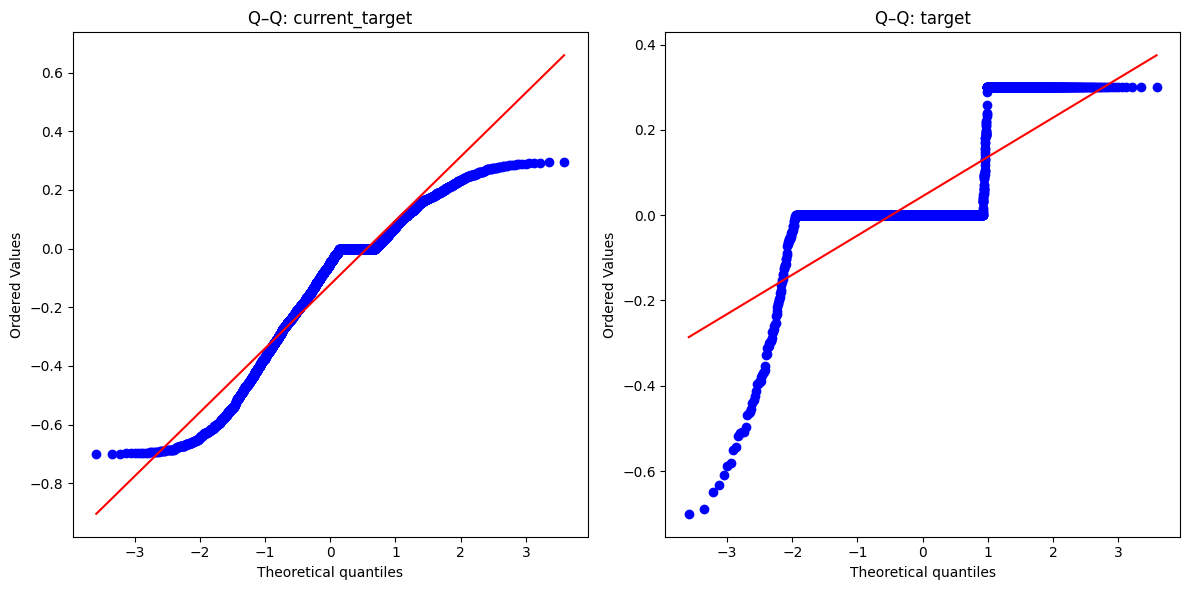

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

stats.probplot(thesis_1["current_target"], dist="norm", plot=axes[0])
axes[0].set_title("Q–Q: current_target")

stats.probplot(thesis_1["target"], dist="norm", plot=axes[1])
axes[1].set_title("Q–Q: target")

plt.tight_layout()
plt.show()

<Axes: xlabel='curr_return_group', ylabel='target'>

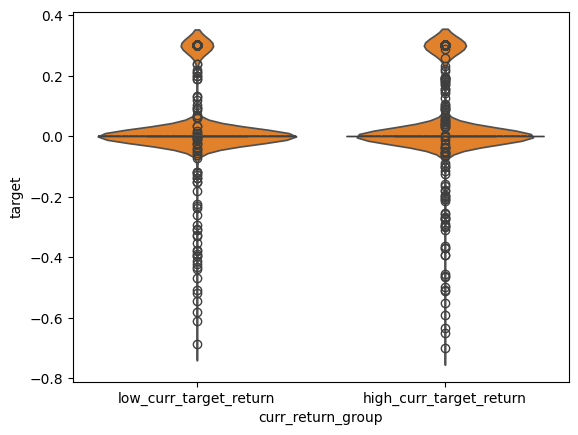

In [9]:
sns.boxplot(x="curr_return_group", y="target", data=thesis_1)
sns.violinplot(x="curr_return_group", y="target", data=thesis_1, inner="quartile")


<Axes: xlabel='target', ylabel='Count'>

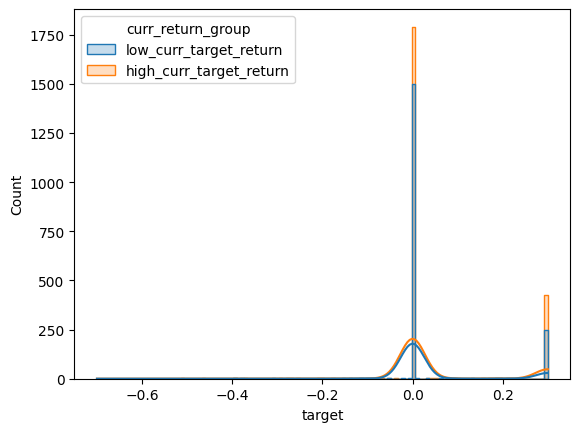

In [10]:
sns.histplot(data=thesis_1, x="target", hue="curr_return_group", kde=True, element="step")


<Axes: xlabel='curr_return_group', ylabel='target'>

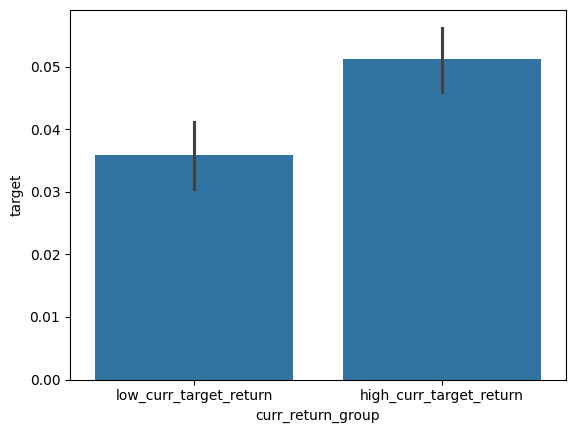

In [11]:
sns.barplot(x="curr_return_group", y="target", data=thesis_1, errorbar=('ci', 95))


<Axes: xlabel='curr_return_group', ylabel='target'>

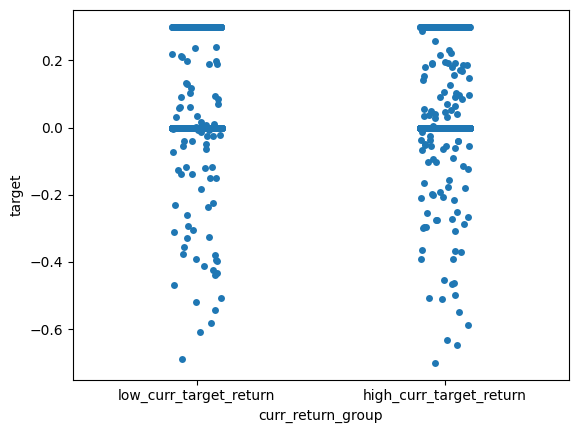

In [12]:
sns.stripplot(x="curr_return_group", y="target", data=thesis_1, jitter=True)


# Гипотеза №2.

In [13]:
thesis_2 = df.copy()

In [14]:
thesis_2["first_login"] = pd.to_datetime(thesis_2["first_login"])
thesis_2["reg_dt"] = pd.to_datetime(thesis_2["reg_dt"])
thesis_2["first_buy"] = pd.to_datetime(thesis_2["first_buy"])

thesis_2["date_correct?"] = "ок"

purchase_no_date = (thesis_2["total_buy"] > 0) & thesis_2["first_buy"].isna()
reg_after_login = thesis_2["reg_dt"] > thesis_2["first_login"]
login_after_buy = thesis_2["first_login"] > thesis_2["first_buy"]
reg_after_buy = thesis_2["reg_dt"] > thesis_2["first_buy"]

invalid_condition = purchase_no_date | reg_after_login | login_after_buy | reg_after_buy

thesis_2.loc[invalid_condition, "date_correct?"] = "исключаем"

exclude = (thesis_2["date_correct?"] == "исключаем").sum()
correct = (thesis_2["date_correct?"] == "ок").sum()

print(f"Исключаем: {exclude}")
print(f"Корректные данные: {correct}")


Исключаем: 16068
Корректные данные: 7121


### Построение нулевой и альтернативной гипотез.

Низкая вовлеченность пользователя: чем больше интервал между первой покупкой и регистрацией, тем ниже изначальная заинтересованность, что увеличивает вероятность возврата. Сравнение по группам интервалов: `до 7 дней` | `после` - есть ли статистически значимые различия `target` между этими группами:
 - Нулевую гипотеза H<sub>0</sub>: "Между количеством дней, прошедших с момента регистрации до первой покупки `days_to_first_buy` и `target` нет связи"
 - Альтернативная гипотеза H<sub>1</sub>: "Чем больше интервал между первой покупкой и регистрацией, тем ниже изначальная заинтересованность и выше риск, что `target` примет отрицательное значение"

### Выбор уровня значимости.

Примем уровень значимости на уровне `alpha = 0.05`

### Данные для проверки гипотезы.

In [15]:
# Оставляем только корретные даты
thesis_2 = thesis_2[thesis_2["date_correct?"] == "ок"]

# Количество дней от регистрации до первой покупки
thesis_2["days_to_first_buy"] = (thesis_2["first_buy"] - thesis_2["reg_dt"]).dt.days

thesis_2[["days_to_first_buy", "target"]].head()

,days_to_first_buy,target
0,217.0,0.0
5,297.0,0.3
8,248.0,0.0
11,1.0,0.0
20,79.0,0.0


### Выбор статистического теста.

Так как распределение не нормальное, а групп две, то для определния корреляции используем тест Спирмена.

### Проведение статистического теста, вычисление p-value.

In [16]:
corr_data = thesis_2[["days_to_first_buy", "target"]].dropna()
spearman_corr, p_value = stats.spearmanr(corr_data["days_to_first_buy"], corr_data["target"])

print(f"Коэффициент Спирмена: {spearman_corr:.4f}")
print(f"P-value: {p_value:.6f}")

Коэффициент Спирмена: 0.0369
P-value: 0.001882


### Сравнение p-value c уровнем значимости и вывод.

1. Значения `p-value = 0.001882` < `alpha = 0.05` --> нулевая гипотеза отвергается.
2. При уровне значимости 5% обнаружена статистически значимая разница между группами. Клиенты с низким числом дней до первой покупки имеют более низкий риск возврата в будущем.

# Гипотеза №3.

In [17]:
thesis_3 = df.copy()

In [18]:
quant = thesis_3["platform_num"].quantile(0.99)

thesis_3 = thesis_3[thesis_3["platform_num"] < quant]

### Построение нулевой и альтернативной гипотез.

Мы соформировали две группы пользователей приняв, что группу до 8 устройст составляют те, кто единолично используют аккаунт, а группу более 8 устройст составляют "Семейные аккаунты" с которых сидит несколько человек или аккаунты конкурентов, перекупщиков и тд.:
 - Нулевую гипотеза H<sub>0</sub>: "Не существует различий в выбранной центральной мере возврат/покупка `target` между группами"
 - Альтернативная гипотеза H<sub>1</sub>: "Имеются существенные различия в выбранной центральной мере возврат/покупка `target` между группами"

### Выбор уровня значимости.

Примем уровень значимости на уровне `alpha = 0.05`

### Данные для проверки гипотезы.

In [19]:
# разбиение на группы по количеству используемых устройств
platform_bins = [1, 8, np.inf]
platform_labels = ["low", "high"]
thesis_3["platform_num_group"] = pd.cut(
    thesis_3["platform_num"],
    bins=platform_bins,
    labels=platform_labels,
    right=False,
)

# добавление метки о подозрительном количестве устройств
trigger = 10
thesis_3["unexpected_platform_num"] = df["platform_num"] >= trigger

In [20]:
low_platform_group = thesis_3.loc[
    thesis_3["platform_num_group"] == "low",
    "target",
]

high_platform_group = thesis_3.loc[
    thesis_3["platform_num_group"] == "high",
    "target",
]

display(low_platform_group.describe())
display(high_platform_group.describe())

count    18890.000000
mean         0.016709
std          0.074607
min         -0.700000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.300000
Name: target, dtype: float64

count    4067.000000
mean        0.040465
std         0.111310
min        -0.687654
25%         0.000000
50%         0.000000
75%         0.000000
max         0.300000
Name: target, dtype: float64

### Выбор статистического теста.

Так как нам необходимо найти различия центральных харктеристик двух групп попробуем применить тесты:
1. ANOVA
2. H-критерий Краскела — Уоллиса

### Анализ на предмет применимости теста ANOVA. 

Для данного теста необходимо чтобы:
1. Распределения были нормальными.
2. Их std равны.

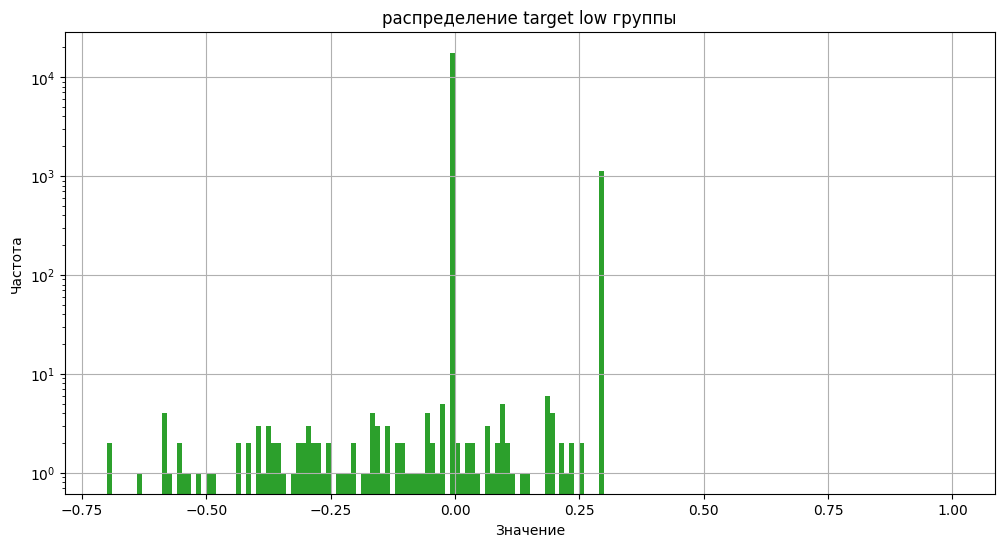

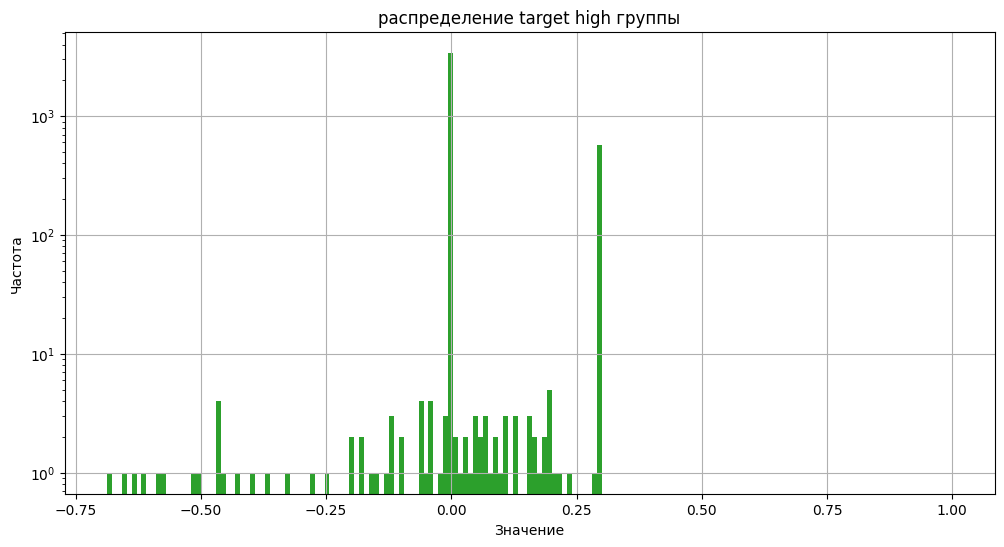

Средний target для групп low: 0.016708680816587957, height: 0.04046498541883623 height/low: 2.421794147785959
ANOVA p_value 3.240840588163268e-62


In [21]:
# Тест ANOVA

# для данного теста требуется равенство std групп и их нормальные распределения.
# std target анализируемых групп не сильно отличаются друг от друга, однако распределения групп не явдяются нормальными.
plt.figure(figsize=(12, 6))
plt.plot(1, 2, 1)
thesis_3[thesis_3["platform_num_group"] == "low"]["target"].hist(bins=100, log=True)
plt.title("распределение target low группы")
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(1, 2, 1)
thesis_3[thesis_3["platform_num_group"] == "high"]["target"].hist(bins=100, log=True)
plt.title("распределение target high группы")
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show()

# поскольку распределения не являются нормальными данный тест не применим
# однако обратим внимание на среднии target по группам 
print(f"Средний target для групп low: {low_platform_group.mean()}, height: {high_platform_group.mean()} height/low: {high_platform_group.mean()/low_platform_group.mean()}")

f_statistic, p_value = stats.f_oneway(low_platform_group, high_platform_group)

print(f"ANOVA p_value {p_value}")

std target анализируемых групп отличаются друг от друга, однако распределения групп не явдяются нормальными, поэтому тест ANOVA нельзя применить.

### Проведение статистического теста, вычисление p-value.

In [22]:
h_statistic, p_value = stats.kruskal(low_platform_group, high_platform_group)

print(f"H-критерий Краскела-Уоллиса: {h_statistic}, p-value: {p_value:.4e}")

H-критерий Краскела-Уоллиса: 300.6040579528067, p-value: 2.4331e-67


### Сравнение p-value c уровнем значимости и вывод.

1. Значения `p-value = 2.4331e-67` << `alpha = 0.05` --> нулевая гипотеза отвергается.
2. При уровне значимости 5% обнаружена статистически значимая разница между группами. Клиенты с низким количеством платформ в среднем имеют более низкий риск возврата в будущем по сравнению с клиентами с высоким количеством платформ.